# Dependencias y funciones

In [1]:
import requests
import base64
import io
import IPython.display
import pandas as pd
from PIL import Image
from datetime import datetime

In [2]:
def call(path_to_file='/home/francisco/Documentos/tfm/utils/sample.jpg', url="http://ec2-15-188-9-114.eu-west-3.compute.amazonaws.com:60210/detection"):

    payload = {}
    files = [
        ('file', open(path_to_file,'rb'))
    ]
    headers= {}

    response = requests.request("POST", url, headers=headers, data = payload, files = files)

    return response

# Llamada a la API

He sustituido el clúster de OKD por AWS Fargate; cómputo sin servidor para contenedores.

Tan sólo ha sido necesario subir un contenedor docker con mi aplicación a AWS Elastic Container Registry y con AWS Fargate provisionarlos a través de AWS Load Balancer.

Contaré en la memoria que esto proporciona alta disponibilidad, capacidad de escalado en función de la demanda de peticiones, etc.

Lo mejor de todo es que no pagas por máquinas virtuales completas si no por cpu y memoria que usan tus procesos; hay un modo 'spot' que no te asegura que tus aplicaciones se interrumpan pero te hacen un 90% de descuento sobre el precio de uso bajo demanda. El balanceador de carga se ocupa de revisar el estado de los procesos en ejercución para lanzar nuevas instancias de los misos de manera indefinida.

¡¡¡Las peticiones suelen atenderse en 4-5 segundos sin usar GPU!!!

https://aws.amazon.com/es/fargate/?whats-new-cards.sort-by=item.additionalFields.postDateTime&whats-new-cards.sort-order=desc&fargate-blogs.sort-by=item.additionalFields.createdDate&fargate-blogs.sort-order=desc

https://aws.amazon.com/es/ecr/

https://aws.amazon.com/es/elasticloadbalancing/

In [68]:
response = call(path_to_file='./utils/sample.jpg', url="http://ec2-15-188-9-114.eu-west-3.compute.amazonaws.com:60210/detection")

In [31]:
response = call(path_to_file='./utils/sample_night_lights_off.jpg', url="http://localhost:60210/detection")

In [10]:
response = call(path_to_file='./utils/sample_night_lights_off.jpg', url="http://thewhitehonet.ddns.net:60210/detection")

KeyboardInterrupt: 

In [32]:
data = response.json()
print(f"Request time: {data['elapsed']}s")
print(f"Request init: {data['init']}")
print(f"Request end: {data['end']}")

Request time: 7.422s
Request init: 2020-12-17 00:28:37.064592
Request end: 2020-12-17 00:28:44.486188


# Tratamiendo de la respuesta

El proceso tiene 3 partes:

    1. Detección de dedos índices + carteles con YOLOv3
    2. Cálculo de area de solapamiento entre caja de dedo + caja de panel, corte de la imagen y proceso de OCR.
    3. Cálculo de la distancia de Levenshtein entre la detección del OCR y los comercios dados de Alta en BBDD. Búsqueda en BBDD y recuperación de mensajes de comercio.

## Paso 1

En la imagen puede verse la detección de los carteles y los dedos índices presentes en la imagen. 

Me estoy quedando con las que tienen confidence >= 75.

Elapsed time: 5.196s
Confidence: 40 Class: 1
Confidence: 47 Class: 1
Confidence: 83 Class: 1
Confidence: 84 Class: 1
Confidence: 32 Class: 0


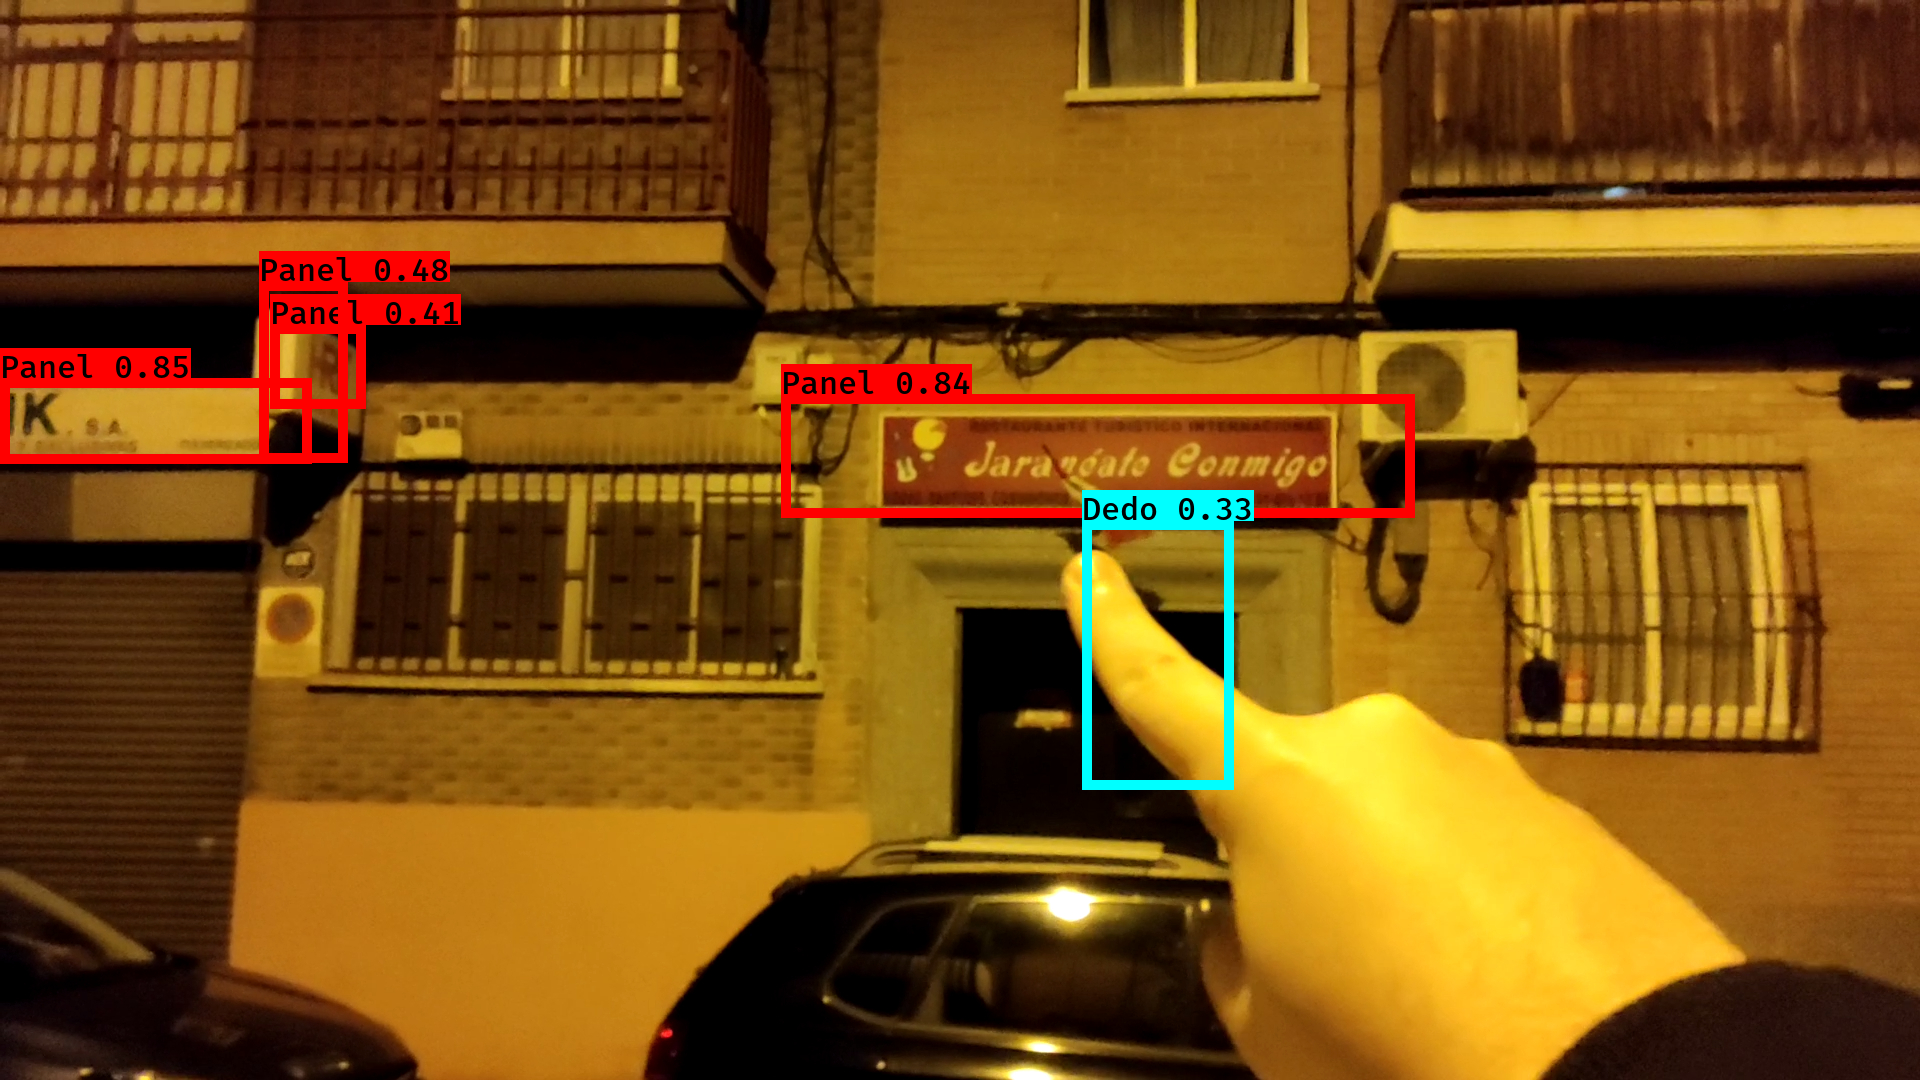

In [34]:
response_detection = data['response']['response_detection']
print(f"Elapsed time: {response_detection['elapsed']}s")
for p in response_detection['payload']['result'][0]['predictions']:
    print("Confidence: %d Class: %d" % (p[-2][-1], p[-2][0]))
msg = base64.b64decode(response_detection['payload']['result'][0]['image'])
buf = io.BytesIO(msg)
img = Image.open(buf)
IPython.display.Image(data=buf.getvalue())

# Paso 2

Después de encontrar solapamiento (en caso de existir varios me quedo con el que maximiza el área) entre un dedo índice y un cartel, corto la imagen por las coordenadas del panel y llamo al servicio de AWS Rekognition.

En la imagen se ilustra el corte, el area donde el OCR ha encontrado texto y los textos.

https://aws.amazon.com/es/rekognition/

Elapsed time: 2.194s
OCR response
------------
F

Jaravoate Conmigo

F

Jaravoate

Conmigo

*****
Image
-----


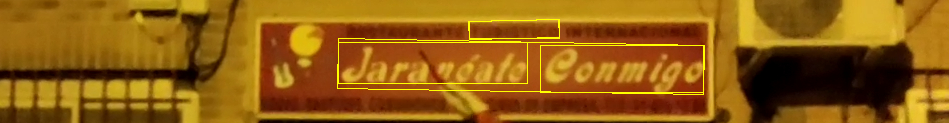

In [35]:
response_rekognition = data['response']['response_rekognition']
print(f"Elapsed time: {response_rekognition['elapsed']}s")
print("OCR response")
print("------------")
for item in response_rekognition['payload']['text']['TextDetections']:
    print(item['DetectedText']+'\n')
print("*****")
print("Image")
print("-----")
msg = base64.b64decode(response_rekognition['payload']['image'])
buf = io.BytesIO(msg)
img = Image.open(buf)
IPython.display.Image(data=buf.getvalue())

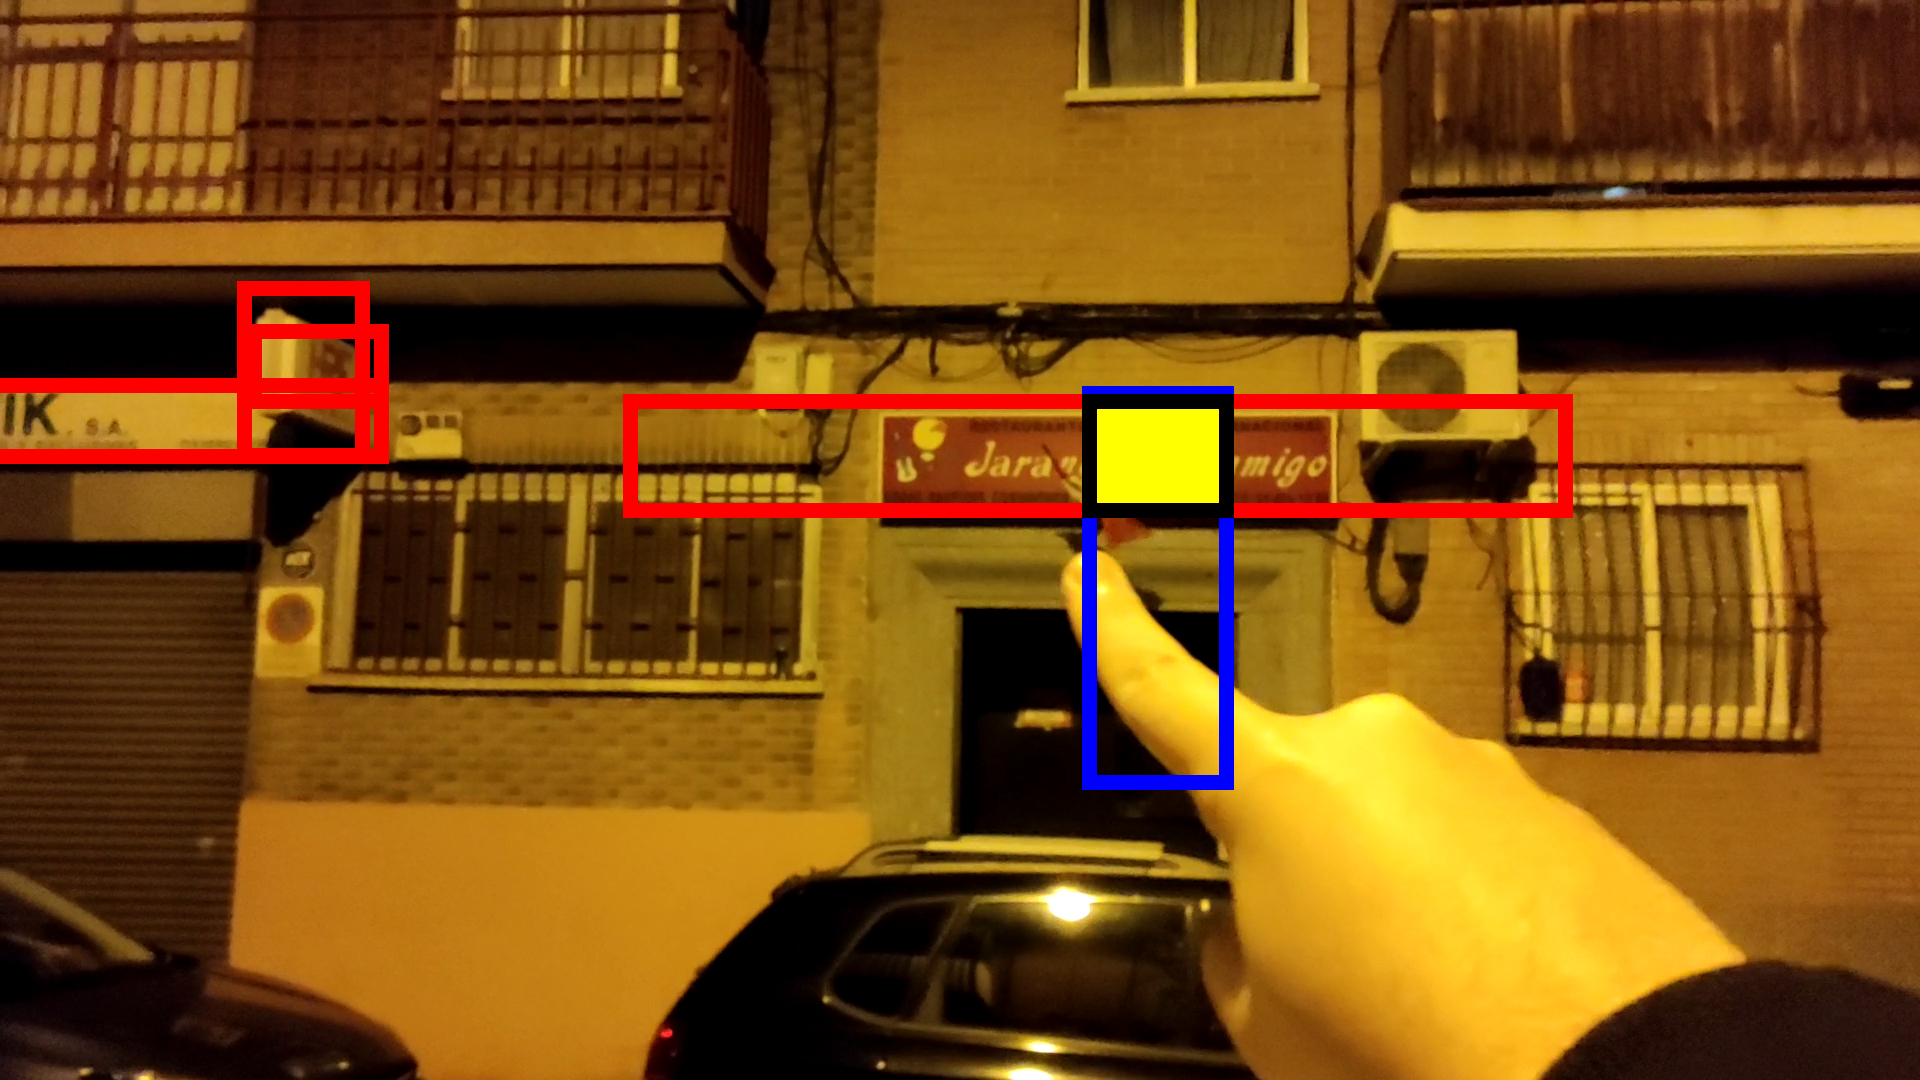

In [37]:
msg = base64.b64decode(response_rekognition['payload']['image_processed'])
buf = io.BytesIO(msg)
img = Image.open(buf)
IPython.display.Image(data=buf.getvalue())

# Paso 3

Actualmente sçólo hay un comercio en base de dados (CALZADOS M&N) por lo que calculo la distancia de Levenshtein entre cada texto encontrado por el OCR y el usuario disponible. Soporta sin problemas más usuarios.

Me quedo con el que minimice la distancia (filtrando las que la distancia es mayor que 2/5 partes de la longitud de la cadena que representa al usuario) y recupero de MongoDB los mensajes asociados del usuario detectado (publicados vía Telegram).

In [36]:
response_processing = data['response']['response_processing']
print(f"Elapsed time: {response_processing['elapsed']}s")
print(f"Comprobaciones:")
txt = "Input OCR,Comercio,Distancia\n"
for item in response_processing['payload']['matches']:
    # print(f"Input OCR: {item[2]} Comercio: {item[1]} Distancia: {item[0]}")
    iitem = item.copy()
    iitem.reverse()
    txt += ','.join(list(map(lambda x: str(x), iitem))) + '\n'
print(pd.read_csv(io.StringIO(txt)))
print("--------")
print(f"Usuario: {response_processing['payload']['user']}")
print("--------")
print("Mensajes publicados")
print("--------")
for item in response_processing['payload']['messages']:
    print(f'DATE: {datetime.fromtimestamp(1602693834)}'),
    print(item)
    print("--------")
response_processing['payload']['opinions'] = [{
    'date': datetime.fromtimestamp(1607351214),
    'msg': "#calzados_m&n El trato humano es sensacional! Fui a comprar calzado específico que me permitiera subir al monte y el dependiente me recomendo ir el lunes en lugar del martes dado que hacen una ofrenda floral que resulta maravillosa a la vista."
}]
print("Opiniones de usuarios")
print("--------")
for item in response_processing['payload']['opinions']:
    print(f"DATE:{item['date']}")
    print(f"{item['msg']}")
    print("--------")
response_processing['payload']['sensors'] = [{
    'DATE': datetime.fromtimestamp(1607536873),
    'Temperatura ambiente': "22ºC",
    'Ocupación': "3"
}]
print("Datos de sensores")
print("--------")
for item in response_processing['payload']['sensors']:
    for k, v in item.items():
        print(f"{k}:{v}")
    print("--------")

Elapsed time: 0.018s
Comprobaciones:
           Input OCR      Comercio  Distancia
0                  F  CALZADOS M&N          9
1  Jaravoate Conmigo  CALZADOS M&N          9
2                  F  CALZADOS M&N          9
3          Jaravoate  CALZADOS M&N          9
4            Conmigo  CALZADOS M&N          9
--------
Usuario: None
--------
Mensajes publicados
--------
DATE: 2020-10-14 16:43:54
No se ha encontrado usuario...
--------
Opiniones de usuarios
--------
DATE:2020-12-07 14:26:54
#calzados_m&n El trato humano es sensacional! Fui a comprar calzado específico que me permitiera subir al monte y el dependiente me recomendo ir el lunes en lugar del martes dado que hacen una ofrenda floral que resulta maravillosa a la vista.
--------
Datos de sensores
--------
DATE:2020-12-09 18:01:13
Temperatura ambiente:22ºC
Ocupación:3
--------
